In [1]:
import os
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm
sm.set_framework('keras')
import ad_seg_utils as seg_utils
import bb_eval_utils as eval_utils
import csv
import math
import sys
from collections import Counter

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [2]:
# Function written by Zihao Wang, descriptions as below
def listdir_nohidden(path, is_train=True):
    """Generate a list contains all the non-hidden files in the given path,
    this is to exclude system hidden files such as .DS_Store
    - feature added: sort the list to prevent images and masks are not 1-to-1 corresponded.

    # Arguments
        path: directory to the image folder

        is_train: boolean variable shows whether this function is used in model training

    # Returns
        return a sorted list which contains all the non-hidden files in the given path

    """
    file_list = [file for file in os.listdir(path) if not file.startswith('.')]
    # print('before', file_list)
    if not is_train:
        if any("_aug" in string for string in file_list):
            file_list = [f.replace('_aug', '') for f in file_list]
            file_list = sorted(file_list)
            file_list = [f.replace('.jpg', '_aug.jpg') for f in file_list]
        # print("aug detected!")
        else:
            file_list = sorted(file_list)


    return file_list


Program initiating... type of segmentation: skin, type of dataset: base
reading test images from: /rds/general/user/ym521/home/EczemaNet-DeepLearning-Segmentation-master/data/dataset_SWET/test_set_SWET_fewer/reals
reading test masks from: /rds/general/user/ym521/home/EczemaNet-DeepLearning-Segmentation-master/data/dataset_SWET/test_set_SWET_fewer/labels
Trained model loaded!


sh: which: line 1: syntax error: unexpected end of file
sh: error importing function definition for `which'
sh: module: line 1: syntax error: unexpected end of file
sh: error importing function definition for `module'
sh: scl: line 1: syntax error: unexpected end of file
sh: error importing function definition for `scl'
sh: ml: line 1: syntax error: unexpected end of file
sh: error importing function definition for `ml'


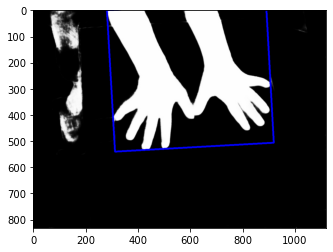

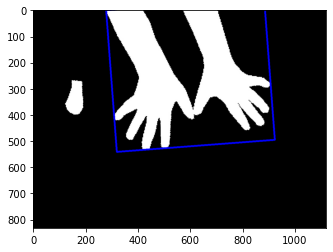

Done!


In [4]:
def main():
    ################################ Model loading (this part will be replaced with new data type soon) ################################
    SEGMENTATION = 'skin'
    SUFFIX = 'base'
    MODEL_NAME = '/skin_base/base_skin_LR1.h5'

    print("Program initiating... type of segmentation: " + SEGMENTATION + ", type of dataset: " + SUFFIX)

    BIN_SEG = True
    CLASSES = ['background', 'skin']
    WEIGHTS = np.array([1, 1])
    target_idx = 1
    BACKBONE = 'efficientnetb3'
    preprocess_input = sm.get_preprocessing(BACKBONE)

    # set parameters based on the type of segmentation
    if SEGMENTATION == 'SKIN' or SEGMENTATION == 'skin':
        pass
    elif SEGMENTATION == 'AD' or SEGMENTATION == 'ad':
        BIN_SEG = False
        target_idx = 2
        CLASSES = ['background', 'skin', 'eczema']
        WEIGHTS = np.array([1, 1, 1])
    else:
        print('Unexpected type of segmentation, should be either skin or ad\n program terminated')
        return -1

    """# Model Evaluation"""
    PROJ_DIR = "/rds/general/user/ym521/home/EczemaNet-DeepLearning-Segmentation-master"
    OUTPUT_DIR = os.path.join(PROJ_DIR, 'output_trained_on_SWET')
    # I changed here
    PRED_DIR = os.path.join(OUTPUT_DIR, 'predictionss/' + SEGMENTATION + '_' + SUFFIX)
    BB_DIR = os.path.join(OUTPUT_DIR, 'bounding_boxes')
    EVAL_DIR = os.path.join(OUTPUT_DIR, 'evaluations')
    MODEL_DIR = os.path.join(OUTPUT_DIR, 'models')
    DATA_DIR = os.path.join(PROJ_DIR, 'data')

    # new dataset
    x_test_dir = os.path.join(DATA_DIR, 'dataset_SWET/test_set_SWET_fewer/reals')
    # x_test_dir = os.path.join(DATA_DIR, 'TLA4AE_origin')
    # y_test_dir = '/rds/general/user/ym521/home/Make_TLA_mask/output'
    y_test_dir = os.path.join(DATA_DIR, 'dataset_SWET/test_set_SWET_fewer/labels')
     
    print('reading test images from: ' + str(x_test_dir))
    print('reading test masks from: ' + str(y_test_dir))

    test_dataset = seg_utils.Dataset(
        x_test_dir, 
        y_test_dir, 
        classes=CLASSES, 
        augmentation=None,
        preprocessing=seg_utils.get_preprocessing(preprocess_input),
        is_train=False,
        use_full_resolution=False,
        binary_seg=BIN_SEG,
    )
    eczema_dataset = seg_utils.Dataset(
        x_test_dir, 
        y_test_dir, 
        classes=['background', 'skin', 'eczema'],
        augmentation=None,
        preprocessing=seg_utils.get_preprocessing(preprocess_input),
        is_train=False,
        use_full_resolution=False,
        binary_seg=0,
    )

    model = seg_utils.load_model(dir=MODEL_DIR+MODEL_NAME, classes=CLASSES, weights=WEIGHTS)
    print('Trained model loaded!')

    ################################ Mask prediction and evaluation ################################
    """# Saving Masks Predictions"""
    # save all predictions 
    # clear previous predictions
#     print('Creating directories and clearing previous masks...')
    os.system("mkdir -p " + PRED_DIR)
#     os.system("rm " + PRED_DIR + "/*.jpg")
#     os.system("rm " + PRED_DIR + "/*.JPG")
#     os.system("rm " + BB_DIR + "/*.jpg")
#     os.system("rm " + BB_DIR + "/*.JPG")
#     os.system("rm " + EVAL_DIR + "/bb_evaluation_" + SEGMENTATION + "_" + SUFFIX + ".csv")
#     print('Done! Now saving new prediction masks...')
    
    # Feb 8: export evaluation result as csv file 
    cov = []
    prec = []
    f1 = []
# for i in range(len(test_dataset)):
    for i in range(51, 52):

        image, _ = test_dataset[i]
        _, gt_mask = eczema_dataset[i]  
        
        # For predicted masks
        image = np.expand_dims(image, axis=0)            
        pr_mask = model.predict(image)      
        # change the last number to decide which mask to output. [0: background; 1: skin; 2: eczema]
        pr_img = pr_mask[0,:,:,target_idx]
        pr_img = (pr_img * 255).astype(np.uint8)         
        cv2.imwrite(os.path.join(PRED_DIR, "pred_" + test_dataset.images_ids[i]), pr_img)
        # generate bounding boxes for each predicted mask
        pr_img = cv2.imread(os.path.join(PRED_DIR, "pred_" + test_dataset.images_ids[i]))
        pr_result, pr_boxes = eval_utils.draw_countours(pr_img)
        
        # For ground truth masks
        gt_mask = np.expand_dims(gt_mask, axis=0)
        gt_mask = gt_mask[0,:,:,1] + gt_mask[0,:,:,2]
        gt_mask = (gt_mask * 255).astype(np.uint8)
        cv2.imwrite(os.path.join(PRED_DIR, "mask_" + test_dataset.images_ids[i]), gt_mask)
        # generate bounding boxes for each ground truth mask
        gt_mask = cv2.imread(os.path.join(PRED_DIR, "mask_" + test_dataset.images_ids[i]))  
        gt_result, gt_boxes = eval_utils.draw_countours(gt_mask)
        
 
        
        
#         # Feb 8: compute performance of bounding boxes
#         coverage_per_image, precision_per_image, f1_per_image, acc_per_image, dice_per_image, [TP_per, TN_per, FP_per, FN_per] = eval_utils.compute_coverage_precision(gt_mask, gt_boxes, pr_boxes, target_idx=2)
#         cov.append(coverage_per_image)
#         prec.append(precision_per_image)
#         f1.append(f1_per_image)

        print('Done!')

if __name__ == "__main__":
    main()